In [127]:
import numpy as np
import matplotlib.pyplot as plt
import sys

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

import qutip

save_figures = False
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Dispersive_Simulations"

sys.path.append("../utils")

## Simulate Qubit
We take the qubit from Elie Genois - Quantum-tailored readout strategies for quantum error correction - DOI:https://doi.org/10.1103/PRXQuantum.2.040355


In [128]:
sample_size    = 100
drive_freq     = "inbetween" # "inbetween", "q0" or "q1"

name = "test_sample"

In [86]:
## Setup parameters:
simulation_steps = 1001

# Setup Qubit, Resonator and Coupling
qubit_states    = 3
n_cutoff        = 15
EJ              = 10 * 2 * np.pi # h GHz
EC              = EJ / 25

resonator_states        = 20
resonator_frequency     = 6.02 * 2 * np.pi    

coupling_strength       = 0.250 * 2 * np.pi


# Setup drive
drive_amplitude        = 0.015
driving_time           = (0, 1000)
# drive_function         = lam'bda t, args: drive_amplitude * np.cos(args["driving_frequency"] * t)


# Loss parameters:
# Setup the qubit decay
rate_qubit_decay  = 1 / 10_000 # T1 time is 10 us
rate_qubit_excite = 0.0        # No excitation, could be introduced by temperature

readout_photon_rate = 0.1      # This is around optimal for this qubit kappa = 2 \chi 
readout_efficiency  = 1


# Define Qubit object
import components as comp
qubit = comp.Transmon(
    EC = EC,
    EJ = EJ,
    basis = "charge",
    n_cutoff = n_cutoff
)
# Define resonator operators
from qutip import destroy
a       = destroy(resonator_states)
a_dag   = a.dag()


# Get Qubit operators for the two level qubit
H_qubit, jump_matrix = qubit.lowest_k_eigenstates(k = qubit_states)

In [87]:
# Derived quantities

# Calculate all types of constants, which is useful for further analysis:
omega_01 = H_qubit.diag()[1] - H_qubit.diag()[0]
omega_02 = H_qubit.diag()[2] - H_qubit.diag()[0]
omega_12 = H_qubit.diag()[2] - H_qubit.diag()[1]

# Calculate the dispersive shifts
# Multi qubit shifts
g_squared_matrix    = coupling_strength ** 2 * abs(jump_matrix.full()) ** 2
omega_ij_matrix     = np.expand_dims(H_qubit.diag(), 1) - np.expand_dims(H_qubit.diag(), 0)
omega_r             = resonator_frequency

# The Chi-matrix
chi_matrix          = g_squared_matrix * (1 / (omega_ij_matrix - omega_r) + 1 / (omega_ij_matrix + omega_r)) 

# The dis
dispersive_shifts   = chi_matrix.sum(axis = 1) / 2 / np.pi


# Omega resonator for qubits
omega_resonator_qubit = resonator_frequency + dispersive_shifts

# Print
print_dict = {
    "omega_01 / h": omega_01 / (2 * np.pi),
    "omega_02 / h": omega_02 / (2 * np.pi),
    "omega_12 / h": omega_12 / (2 * np.pi),
    "omega_r / h": omega_r / (2 * np.pi),
    "omega_r_q0 / h": omega_resonator_qubit[0] / (2 * np.pi),  
    "omega_r_q1 / h": omega_resonator_qubit[1] / (2 * np.pi),
    "omega_r_q2 / h": omega_resonator_qubit[2] / (2 * np.pi),
    "dispersive_shift": (dispersive_shifts[0] - dispersive_shifts[1]) / (2 * np.pi),
}

for key, value in print_dict.items():
    print(f"{key}: \t{value:.3f} GHz")

omega_01 / h: 	5.222 GHz
omega_02 / h: 	9.923 GHz
omega_12 / h: 	4.700 GHz
omega_r / h: 	6.020 GHz
omega_r_q0 / h: 	6.029 GHz
omega_r_q1 / h: 	6.020 GHz
omega_r_q2 / h: 	6.010 GHz
dispersive_shift: 	0.009 GHz


## Define Hamiltonian - Dispersive limit:

Non interacting:  

$H_{eff} = (\omega_r - \omega_d  + \sum_k \chi_k \ket{k}\bra{k} ) a^\dagger a$

Driving

$H_{d, eff} = \epsilon (a^\dagger + a)$

In [88]:
from qutip import tensor

# Drive inbetween the two qubit states
drive_choices = {
    "inbetween": (omega_resonator_qubit[0] + omega_resonator_qubit[1]) / 2,
    "q0": omega_resonator_qubit[0],
    "q1": omega_resonator_qubit[1],
}

drive_frequency = drive_choices[drive_freq] 

# Define the Hamiltonian components. 
H_res   = (omega_r - drive_frequency) * tensor(qutip.qeye(qubit_states), a_dag * a)
H_disp  = tensor(qutip.Qobj(np.diag(dispersive_shifts)), a_dag * a)
H_drive = drive_amplitude * tensor(qutip.qeye(qubit_states), a_dag + a)

H =  H_res + H_disp + H_drive

# Simulations


In [89]:
from qutip import ket2dm, operator_to_vector, create

# Times
tlist = np.linspace(*driving_time, simulation_steps)

# Initial_states
ground_resonator_state = qutip.basis(resonator_states, 0)
ground_qubit_state     = qutip.basis(qubit_states, 0)
excited_qubit_state    = qutip.basis(qubit_states, 1)

# Define operators

## Collapse Operators
# Qubit decay
qubit_decay_operator    = np.sqrt(rate_qubit_decay)     * destroy(qubit_states)
qubit_excite_operator   = np.sqrt(rate_qubit_excite)    * create(qubit_states)

# Resonator decay
resonator_decay_operator = np.sqrt(readout_photon_rate) * destroy(resonator_states)

## Expectation Operators
# Qubit Occupation
qubit_occupation_operator = qutip.num(qubit_states)

# Resonator Occupation
resonator_occupation_operator = qutip.num(resonator_states)

resonator_I = a + a_dag
resonator_Q = 1j * (a - a_dag)

# Define the collapse operators
e_ops = [
    tensor(qutip.qeye(qubit_states), resonator_I),
    tensor(qutip.qeye(qubit_states), resonator_Q)
]


In [90]:
from qutip import vector_to_operator, lindblad_dissipator, spre, spost, liouvillian, qeye, parallel_map
from qutip.expect import expect_rho_vec

from qutip import smesolve

qubit_decay =         tensor(qubit_decay_operator,        qutip.qeye(resonator_states))
qubit_excitation =    tensor(qubit_excite_operator,       qutip.qeye(resonator_states))
photon_decay =        tensor(qutip.qeye(qubit_states),    destroy(resonator_states))


result_ground_stochastic = smesolve(
    H,
    ket2dm(tensor(ground_qubit_state, ground_resonator_state)),
    tlist,
    c_ops  = [qubit_decay, qubit_excitation],
    sc_ops = [np.sqrt(readout_photon_rate) * photon_decay],
    e_ops = e_ops,
    progress_bar = True,
    ntraj = sample_size,
    method = "heterodyne",
    store_measurement = True,
    map_func = parallel_map,
    dW_factors = [1],
    solver = "taylor15"
)

result_excited_stochastic = smesolve(
    H,
    ket2dm(tensor(excited_qubit_state, ground_resonator_state)),
    tlist,
    c_ops  = [qubit_decay, qubit_excitation],
    sc_ops = [np.sqrt(readout_photon_rate) * photon_decay],
    e_ops = e_ops,
    ntraj = sample_size,
    progress_bar = True,
    method = "heterodyne",
    store_measurement = True,
    map_func = parallel_map,
    dW_factors = [1],
    solver = "taylor15"
)


10.0%. Run time:  44.00s. Est. time left: 00:00:06:36
20.0%. Run time:  80.34s. Est. time left: 00:00:05:21
30.0%. Run time:  87.56s. Est. time left: 00:00:03:24
40.0%. Run time: 127.34s. Est. time left: 00:00:03:11
50.0%. Run time: 157.16s. Est. time left: 00:00:02:37
60.0%. Run time: 174.66s. Est. time left: 00:00:01:56
70.0%. Run time: 221.17s. Est. time left: 00:00:01:34
80.0%. Run time: 228.66s. Est. time left: 00:00:00:57
90.0%. Run time: 270.60s. Est. time left: 00:00:00:30
100.0%. Run time: 276.83s. Est. time left: 00:00:00:00
Total run time: 276.85s
10.0%. Run time:  46.86s. Est. time left: 00:00:07:01
20.0%. Run time: 104.52s. Est. time left: 00:00:06:58
30.0%. Run time: 107.53s. Est. time left: 00:00:04:10
40.0%. Run time: 158.99s. Est. time left: 00:00:03:58
50.0%. Run time: 203.51s. Est. time left: 00:00:03:23
60.0%. Run time: 207.67s. Est. time left: 00:00:02:18
70.0%. Run time: 249.72s. Est. time left: 00:00:01:47
80.0%. Run time: 265.43s. Est. time left: 00:00:01:06
90.

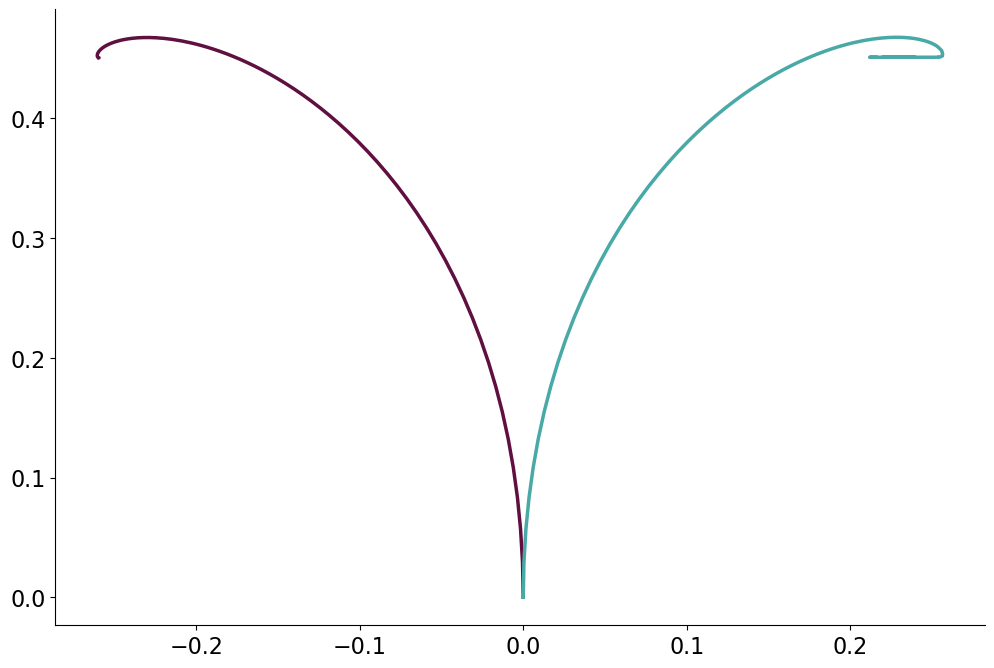

In [95]:
# Extract information
I_ground    = result_ground_stochastic.expect[0]
Q_ground    = result_ground_stochastic.expect[1]
I_excited   = result_excited_stochastic.expect[0]
Q_excited   = result_excited_stochastic.expect[1]

# Plot
fig, ax = plt.subplots(1, 1)
ax.plot(I_ground, Q_ground, label = "Ground")
ax.plot(I_excited, Q_excited, label = "Excited")

In [96]:
scaling_for_exp_value = np.sqrt(2 / readout_photon_rate)

ground_measurement  = scaling_for_exp_value * np.array(result_ground_stochastic.measurement).squeeze()
excited_measurement = scaling_for_exp_value * np.array(result_excited_stochastic.measurement).squeeze()

In [97]:
def rolling_mean(array, window = 500):
    return np.convolve(array, np.ones(window), 'same') / window

In [112]:
limit = 100

def plotting_func(limit):

    for i in range(result_excited_stochastic.ntraj):
        plt.plot(np.cumsum(ground_measurement[i, :limit, 0]),  -np.cumsum(ground_measurement[i, :limit, 1]) , label = "Ground", color = "C0", alpha = 0.1)
        plt.plot(np.cumsum(excited_measurement[i, :limit, 0]), -np.cumsum(excited_measurement[i, :limit, 1]) , label = "Excited", color = "C1", alpha = 0.1)

    plt.scatter(ground_measurement[:, :limit, 0].sum(axis = 1), - ground_measurement[:, :limit, 1].sum(axis = 1) , label = "Ground", color = "C0", alpha = 1)
    plt.scatter(excited_measurement[:, :limit, 0].sum(axis = 1), - excited_measurement[:, :limit, 1].sum(axis = 1) , label = "Excited", color = "C1", alpha = 1)

from ipywidgets import interactive
interactive(plotting_func, limit = (0, 1000, 1))

interactive(children=(IntSlider(value=500, description='limit', max=1000), Output()), _dom_classes=('widget-in…

In [104]:
ground_measurement.shape

(100, 1001, 2)

In [105]:
import pandas as pd

In [129]:
list_to_concat = []
for i in range(result_ground_stochastic.ntraj):
    data = {
        "trajectory": i,
        "initial_state": 0,
        "t": tlist,
        "I": ground_measurement[i, :, 0].real,
        "Q": ground_measurement[i, :, 1].real
    }
    list_to_concat.append(pd.DataFrame(data))

for i in range(result_excited_stochastic.ntraj):
    data = {
        "trajectory": i + result_ground_stochastic.ntraj,
        "initial_state": 1,
        "t": tlist,
        "I": excited_measurement[i, :, 0].real,
        "Q": excited_measurement[i, :, 1].real
    }
    list_to_concat.append(pd.DataFrame(data))

df = pd.concat(list_to_concat)

df.to_csv("simulation_data/" + name + ".csv", index = False)

In [ ]:
name